# Analysis of results

In [2]:
%matplotlib inline

from __future__ import print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from IPython.display import display, HTML
from scipy.stats import ttest_rel
from sklearn.metrics import confusion_matrix

In [3]:
class Results(object):
    def __init__(self, name, exp_name, base_dir, iteration_slice, rtype='test'):
        self.name = name
        self.size = len(iteration_slice)

        for idx, it in enumerate(iteration_slice):
            dirname = os.path.join(base_dir, "iter{}".format(it), exp_name)
            
            for result_kind in ['accuracy', 'precision', 'recall', 'predictions']:
                for rfile in filter(lambda x: x.startswith("{}_{}".format(rtype, result_kind)), os.listdir(dirname)):
                    if "NEU" in rfile:
                        ekind = "NEU"
                    elif "LKIF" in rfile:
                        ekind = "LKIF"
                    elif "NEP" in rfile:
                        ekind = "NEP"
                    else:
                        ekind = "NER"
                    
                    attr_name = "{}_{}".format(result_kind, ekind)
                    filepath = os.path.join(dirname, rfile)
                    
                    if idx == 0:
                        setattr(self, attr_name, [])
                    
                    if result_kind != 'predictions':
                        getattr(self, attr_name).append(np.loadtxt(filepath, delimiter=','))
                    else:
                        df = pd.read_csv(filepath, header=None,
                                         names=["prediction", "prediction_label", "true", "true_label"])
                        
                        if idx == 0:
                            setattr(self, "classes_{}".format(ekind), np.unique(df.true_label.values))
                            setattr(self, "true_{}".format(ekind), df.true.values)
                        
                        getattr(self, attr_name).append(df.prediction.values)

        for attr, value in self.__dict__.iteritems():
            if isinstance(value, list):
                setattr(self, attr, np.array(value))

rng = range(1, 6)

NEU = Results("MLP without CL", "NEU_10500", "../../results/final_results/", rng)
LKIF = Results("MLP without CL", "LKIF_10500", "../../results/final_results/", rng)
CL1 = Results("CL change layer", "CL_10500", "../../results/final_results/", rng)
CL2 = Results("CL remove layer", "CL_10500_10172_7_3", "../../results/final_results/", rng)

NEU_pairs = [(NEU, CL1), (NEU, CL2), (CL1, CL2)]
LKIF_pairs = [(LKIF, CL1), (LKIF, CL2), (CL1, CL2)]

In [ ]:
col_names = np.array(["Experiment 1", "Experiment 2", "Iteration", "Statistic", "P-value", "Significative"])
NEU_df = pd.DataFrame(columns=col_names)

for p1, p2 in NEU_pairs:
    for i in range(p1.size):
        tstat, pvalue = ttest_rel(p1.predictions_NEU[i], p2.predictions_NEU[i])
        values = [p1.name, p2.name, i+1, tstat, pvalue, "Yes" if pvalue < 0.05 else "No"]
        NEU_df = NEU_df.append(dict(zip(col_names, values)), ignore_index=True)

print(NEU_df.to_latex(float_format='{:.2g}'.format, index=False, columns=col_names[col_names != "Statistic"]))
with open("../../paper/NEU_significance.tex", "w") as f:
    print(NEU_df.to_latex(float_format='{:.2g}'.format, index=False, columns=col_names[col_names != "Statistic"]),
          file=f)

In [ ]:
col_names = np.array(["Experiment 1", "Experiment 2", "Iteration", "Statistic", "P-value", "Significative"])
LKIF_df = pd.DataFrame(columns=col_names)

for p1, p2 in LKIF_pairs:
    for i in range(p1.size):
        tstat, pvalue = ttest_rel(p1.predictions_LKIF[i], p2.predictions_LKIF[i])
        values = [p1.name, p2.name, i+1, tstat, pvalue, "Yes" if pvalue < 0.05 else "No"]
        LKIF_df = LKIF_df.append(dict(zip(col_names, values)), ignore_index=True)

print(LKIF_df.to_latex(float_format='{:.2g}'.format, index=False, columns=col_names[col_names != "Statistic"]))
with open("../../paper/LKIF_significance.tex", "w") as f:
    print(LKIF_df.to_latex(float_format='{:.2g}'.format, index=False, columns=col_names[col_names != "Statistic"]),
          file=f)

In [ ]:
NEU_rslt_df = pd.DataFrame(columns="name accuracy precision recall fscore".split())

for rslt in [NEU, CL1, CL2]:
    pmean = rslt.precision_NEU[:, rslt.classes_NEU != 'O'].mean()
    rmean = rslt.recall_NEU[:, rslt.classes_NEU != 'O'].mean()
    NEU_rslt_df = NEU_rslt_df.append({
            "name": rslt.name,
            "accuracy": rslt.accuracy_NEU.mean(),
            "precision": pmean,
            "recall": rmean,
            "fscore": 2 * pmean * rmean / (pmean + rmean)
        }, ignore_index=True)

display(HTML(NEU_rslt_df.to_html(float_format='{:.3f}'.format, index=False)))

In [ ]:
LKIF_rslt_df = pd.DataFrame(columns="name accuracy precision recall fscore".split())
LKIF_rslt_pr = []

for rslt in [LKIF, CL1, CL2]:
    pmean = rslt.precision_LKIF[:, rslt.classes_LKIF != 'O'].mean()
    rmean = rslt.recall_LKIF[:, rslt.classes_LKIF != 'O'].mean()
    LKIF_rslt_df = LKIF_rslt_df.append({
        "name": rslt.name,
        "accuracy": rslt.accuracy_LKIF.mean(),
        "precision": pmean,
        "recall": rmean,
        "fscore": 2 * pmean * rmean / (pmean + rmean)
    }, ignore_index=True)

    LKIF_rslt_pr.append([rslt.name + " precision"] +\
                        list(rslt.precision_LKIF[:, rslt.classes_LKIF != 'O'].mean(axis=0)))
    LKIF_rslt_pr.append([rslt.name + " recall"] + list(rslt.recall_LKIF[:, rslt.classes_LKIF != 'O'].mean(axis=0)))

LKIF_rslt_pr = pd.DataFrame(LKIF_rslt_pr, columns=["Name"] + list(LKIF.classes_LKIF[LKIF.classes_LKIF != 'O']))
    
display(HTML(LKIF_rslt_df.to_html(float_format='{:.3f}'.format, index=False)))
print
display(HTML(LKIF_rslt_pr.to_html(float_format='{:.3f}'.format, index=False)))

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))

_, counts = np.unique(NEU.true_NEU, return_counts=True)
hist = np.histogram(counts, bins=[0, 10, 25, 100, counts.shape[0]])[0]
bins = ["0 <= x < 10", "10 <= x < 25", "25 <= x < 100", "100 <= x"]
ax = sns.barplot(bins, hist)
ax.set(xlabel='Occurrence bins', ylabel='Number of classes', title='Number of Classes per Occurrence Bins')
ax.title.set_y(1.05)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15

# plt.savefig("../../paper/graphics/occurrences.png")

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))

_, counts = np.unique(LKIF.true_LKIF, return_counts=True)
hist = np.histogram(counts, bins= [0, 1e3, 3e4, 1e5, 2e5])[0]
bins = ["Less", "Rare", "Medium", "Most"]
ax = sns.barplot(bins, hist)
ax.set(xlabel='Occurrence bins', ylabel='Number of classes', title='Number of Classes per Occurrence Bins')
ax.title.set_y(1.05)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15

# plt.savefig("../../paper/graphics/occurrences_LKIF.png")

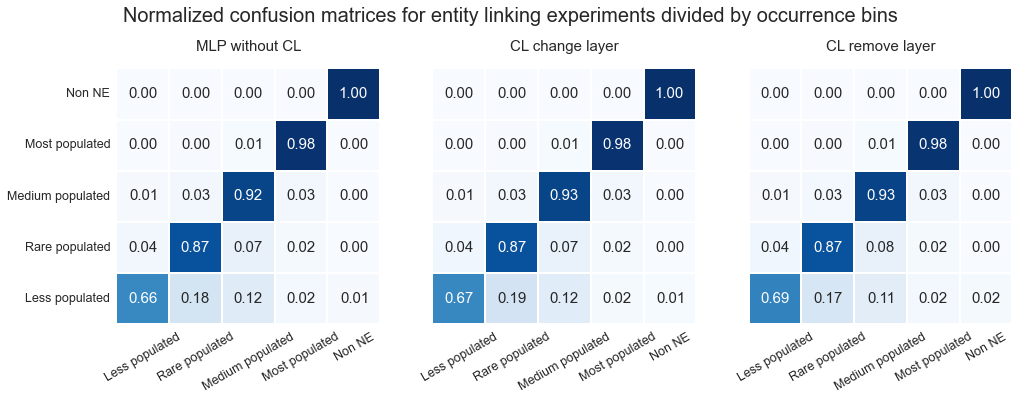

In [10]:
sns.set(font_scale=1.25)

classes, counts = np.unique(NEU.true_NEU, return_counts=True)
most_populated_label = classes[np.argsort(counts)[::-1]][0]

def mapping(label):
    if counts[label] < 10:
        return 0
    elif counts[label] < 25:
        return 1
    elif counts[label] < 100:
        return 2
    elif label == most_populated_label:
        return 4
    else:
        return 3

vmapping = np.vectorize(mapping)
bins = ["Less populated", "Rare populated", "Medium populated", "Most populated", "Non NE"]

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 6))

for idx, rlt in enumerate([NEU, CL1, CL2]):
    true_NEU_mapped = vmapping(rlt.true_NEU)
    pred_NEU_mapped = vmapping(rlt.predictions_NEU[0])

    cm = confusion_matrix(true_NEU_mapped, pred_NEU_mapped)
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_cm = pd.DataFrame(normalized_cm, columns=bins, index=bins)

    ax = sns.heatmap(normalized_cm.reindex(index=normalized_cm.index[::-1]), vmin=0.0, vmax=1.0, annot=True,
                     fmt=".2f", linewidths=.5, cmap="Blues", ax=axes[idx], cbar=False)
    ax.set_title(rlt.name)
    for item in ax.get_xticklabels():
        item.set_rotation(30)
    
    ax.title.set_y(1.05)

fig.suptitle("Normalized confusion matrices for entity linking experiments " +
             "divided by occurrence bins", fontsize=20)
fig.tight_layout(pad=2.5)

plt.savefig("../../paper/graphics/heatmaps_NEU.png")

In [12]:
dataset = []

for t in os.listdir("../../results/final_results/lkif/"):
    with open("../../results/final_results/lkif/" + t, "r") as f:
        dataset.extend([l.strip().split("\t") for l in f.read().decode("utf-8").split("\n") if l.strip() != ''])

dataset = pd.DataFrame(dataset, columns="Instance true_LKIF predictions_LKIF".split())
STF = Results("Stanford NER", "STF", "../../results/final_results/", range(0))
classes, inverse = np.unique(dataset.true_LKIF.values, return_inverse=True)
setattr(STF, 'true_LKIF', inverse)
setattr(STF, 'classes_LKIF', classes)
classes, inverse = np.unique(dataset.predictions_LKIF.values, return_inverse=True)
setattr(STF, 'predictions_LKIF', [inverse])

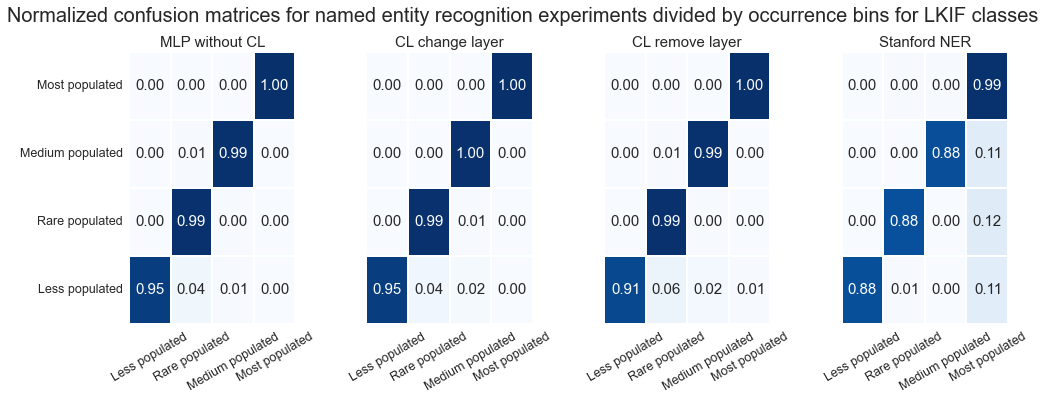

In [36]:
sns.set(font_scale=1.25)

classes, counts = np.unique(LKIF.true_LKIF, return_counts=True)
_, counts_stf = np.unique(STF.true_LKIF, return_counts=True)
most_populated_label = classes[np.argsort(counts)[::-1]][0]

def mapping(label):
    if counts[label] < 1e3:
        return 0
    elif counts[label] < 5e4:
        return 1
    elif counts[label] < 1e5:
        return 2
#     elif label == most_populated_label:
#         return 4
    else:
        return 3

def stf_mapping(label):
    if counts_stf[label] < 1e3:
        return 0
    elif counts_stf[label] < 1e5:
        return 1
    elif counts_stf[label] < 2e5:
        return 2
#     elif label == most_populated_label:
#         return 4
    else:
        return 4

vmapping = np.vectorize(mapping)
vmapping_stf = np.vectorize(stf_mapping)
bins = ["Less populated", "Rare populated", "Medium populated", "Most populated"]#, "Non NE"]

fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(15, 6))

for idx, rlt in enumerate([LKIF, CL1, CL2, STF]):
    if rlt.name != "Stanford NER":
        true_LKIF_mapped = vmapping(rlt.true_LKIF)
        pred_LKIF_mapped = vmapping(rlt.predictions_LKIF[0])
    else:
        true_LKIF_mapped = vmapping_stf(rlt.true_LKIF)
        pred_LKIF_mapped = vmapping_stf(rlt.predictions_LKIF[0])

    cm = confusion_matrix(true_LKIF_mapped, pred_LKIF_mapped)
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_cm = pd.DataFrame(normalized_cm, columns=bins, index=bins)

    ax = sns.heatmap(normalized_cm.reindex(index=normalized_cm.index[::-1]), vmin=0.0, vmax=1.0, annot=True,
                     fmt=".2f", linewidths=.5, cmap="Blues", ax=axes.flatten()[idx], cbar=False)
    ax.set_title(rlt.name)
    for item in ax.get_xticklabels():
        item.set_rotation(30)

fig.suptitle("Normalized confusion matrices for named entity recognition experiments " +
             "divided by occurrence bins for LKIF classes", fontsize=20)
fig.tight_layout(pad=2.5)

plt.savefig("../../paper/graphics/heatmaps_LKIF_2.png")

In [33]:
np.sort(counts_stf)

array([    179,     391,   50879,   55514,   64320,  152817, 3790585])